In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import re
import sqlite3 

In [2]:
df = pd.read_csv('train_preprocess.tsv', encoding='latin-1',sep='\t', names=['text', 'label'])
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [3]:
#Ubah text menjadi lower
def lower(text):
    return text.lower()

In [4]:
def hapuskarakter(text):
    text = re.sub('\n',' ', text)
    text = re.sub('rt',' ', text)
    text = re.sub('user',' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub('  +',' ', text)
    return text

In [5]:
#Baca Table Kamus Alay
db = sqlite3.connect('dbp.db', check_same_thread=False)
db.text_factory = bytes
mycursor = db.cursor()

query = "select * from kamus_alay"
kamusalay = pd.read_sql_query(query, db)
kamusalay['hasil clean'] = kamusalay['hasil clean'].str.decode('utf-8')
kamusalay['kata alay'] = kamusalay['kata alay'].str.decode('utf-8')

alay_dict_map = dict(zip(kamusalay['kata alay'], kamusalay['hasil clean']))
def replace_kamus_alay(text):
    for word in alay_dict_map:
        return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

In [6]:
def cleansing(text):
    text = lower(text)
    text = hapuskarakter(text)
    text = replace_kamus_alay(text)
    return text

In [7]:
df['text_clean'] = df.text.apply(cleansing)
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah pak ai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatra bandung . te...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh . jadi mahasiswa jangan sombong dong . ka...


In [8]:
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns=['label','text'])
df_baru.head()

,text_clean,negative,neutral,positive
0,warung ini dimiliki oleh pengusaha pabrik tahu...,0,0,1
1,mohon ulama lurus dan k212 mmbri hujjah pak ai...,0,1,0
2,lokasi strategis di jalan sumatra bandung . te...,0,0,1
3,betapa bahagia nya diri ini saat unboxing pake...,0,0,1
4,aduh . jadi mahasiswa jangan sombong dong . ka...,1,0,0


In [9]:
x = df_baru['text_clean'].values
y = df_baru[['negative', 'neutral', 'positive']].values

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(x)

In [11]:
sekuens_x = tokenizer.texts_to_sequences(x)

In [12]:
padded_x = pad_sequences(sekuens_x) 

In [13]:
x_train, x_test, y_train, y_test = train_test_split(padded_x, y, test_size=0.2, random_state = 4)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 4)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=4),
    
    tf.keras.layers.LSTM(4),
    
    tf.keras.layers.Dense(4, kernel_regularizer=L1L2(l1=0.01, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(), 
    
#     tf.keras.layers.Dense(4, kernel_regularizer=L1L2(l1=0.01, l2=0.01), activation='relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.Dense(3, activation='softmax')
])

In [15]:
# early_stop = EarlyStopping(monitor='val_categorical_accuracy', mode='min')

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_categorical_accuracy') > 0.85 ):
            self.model.stop_training = True

callbacks = myCallback()

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4)           40000     
                                                                 
 lstm (LSTM)                 (None, 4)                 144       
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                        

In [18]:
%%time
num_epochs = 1000
fit = model.fit(x_train, 
                y_train, 
#                 batch_size = 16,
                epochs=num_epochs, 
                validation_data=(x_val, y_val),
#                 validation_split=0.2,       
                callbacks = [callbacks]
)

Epoch 1/1000
220/220 [==============================] - 14s 42ms/step - loss: 0.9563 - categorical_accuracy: 0.6341 - val_loss: 0.9310 - val_categorical_accuracy: 0.6102
Epoch 2/1000
220/220 [==============================] - 7s 34ms/step - loss: 0.6221 - categorical_accuracy: 0.7675 - val_loss: 0.6520 - val_categorical_accuracy: 0.7653
Epoch 3/1000
220/220 [==============================] - 8s 35ms/step - loss: 0.5015 - categorical_accuracy: 0.8188 - val_loss: 0.4756 - val_categorical_accuracy: 0.8256
Epoch 4/1000
220/220 [==============================] - 8s 34ms/step - loss: 0.4157 - categorical_accuracy: 0.8558 - val_loss: 0.4447 - val_categorical_accuracy: 0.8506
CPU times: total: 1min 20s
Wall time: 36.8 s


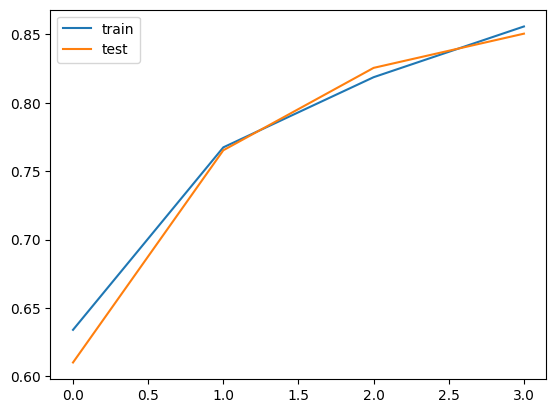

In [19]:
plt.plot(fit.history['categorical_accuracy'], label='train')
plt.plot(fit.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show()

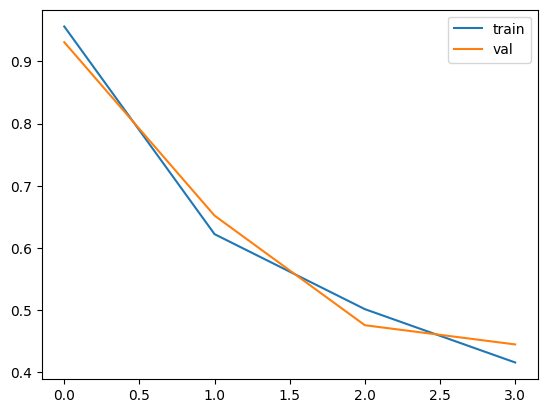

In [20]:
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='val')
plt.legend()
plt.show()

In [21]:
train_loss, train_acc = model.evaluate(x_train, y_train, steps=16)
val_loss, val_acc = model.evaluate(x_val, y_val, steps=16)
test_loss, test_acc = model.evaluate(x_test, y_test, steps=16)

print('\nTrain: %.3f, val: %.3f, test: %.3f,' % (train_acc, val_acc, test_acc))

16/16 [==============================] - 0s 16ms/step - loss: 0.4650 - categorical_accuracy: 0.8486

Train: 0.949, val: 0.851, test: 0.849,


In [22]:
filename = 'Model_LSTM.h5'
model.save(filename)

In [23]:
import io
import json

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))